# 第10章 组合和继承
第6章介绍了Scala面向对象的一些基础概念。本章将接着第6章，更详细地介绍Scala对于面向对象编程的支持。
我们将对比类之间的两个最基本的关系：组合和继承。**组合的意思是一个类可以包含对另一个类的引用，利用这个被引用类来帮助它完成任务；而继承是超类/子类的关系。**

除此之外，我们还会探讨抽象类、无参方法、类的扩展、重写方法和字段、参数化字段、调用超类的构造方法、多态和动态绑定、不可重写（final）的成员和类，以及工厂对象和方法。

## 10.1 一个二维的布局类库
我们将创建一个用于构建和渲染二维布局元素的类库，以此作为本章的示例。每个元素表示一个用文本填充的长方形。为方便起见，类库将提供名为“elem”的工厂方法，从传入的数据构造新的元素。例如，可以用下面这个签名的工厂方法创建一个包含字符串的布局元素：
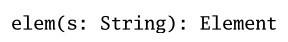

In [ ]:
//package org.stairwaybook.layout

object Element {

  private class ArrayElement(
    val contents: Array[String]
  ) extends Element

  private class LineElement(s: String) extends Element {
    val contents = Array(s)
    override def width = s.length
    override def height = 1
  }

  private class UniformElement(
    ch: Char,
    override val width: Int,
    override val height: Int
  ) extends Element {
    private val line = ch.toString * width
    def contents = Array.fill(height)(line)
  }

  def elem(contents:  Array[String]): Element =
    new ArrayElement(contents)

  def elem(chr: Char, width: Int, height: Int): Element =
    new UniformElement(chr, width, height)

  def elem(line: String): Element =
    new LineElement(line)
}
import Element.elem

abstract class Element {
  def contents:  Array[String]

  def width: Int = contents(0).length
  def height: Int = contents.length

  def above(that: Element): Element = {
    val this1 = this widen that.width
    val that1 = that widen this.width
    elem(this1.contents ++ that1.contents)
  }

  def beside(that: Element): Element = {
    val this1 = this heighten that.height
    val that1 = that heighten this.height
    elem(
      for ((line1, line2) <- this1.contents zip that1.contents) 
      yield line1 + line2)
  }

  def widen(w: Int): Element = 
    if (w <= width) this
    else {
      val left = elem(' ', (w - width) / 2, height) 
      val right = elem(' ', w - width - left.width, height)
      left beside this beside right
    }

  def heighten(h: Int): Element = 
    if (h <= height) this
    else {
      val top = elem(' ', width, (h - height) / 2)
      val bot = elem(' ', width, h - height - top.height)
      top above this above bot
    }

  override def toString = contents mkString "\n"
}

object LayoutElement {
  def main(args: Array[String]) {
    
    println("example [\n" + example + "\n]")
  }

  def example = {
    val column1 = elem("hello") above elem("***")
    val column2 = elem("***") above elem("world")
    column1 beside column2
  }
}

就像你看到的，我们用一个名为Element的类型来对元素建模。可以对一个元素调用above或beside，传入另一个元素，来获取一个将两个元素结合在一起的新元素。例如，下面这个表达式将创建一个由两列组成的更大的元素，每一列的高度都为2：

In [ ]:
println(LayoutElement.example)

布局元素很好地展示了这样一个系统：在这个系统中，对象可以通过组合操作符的帮助由简单的部件构建出来。本章将定义那些可以从数组、线和矩形构造出元素对象的类，这些基础的元素对象是我们说的简单的部件，我们还会定义组合操作符above和beside。这样的组合操作符通常也被称作组合子（combinator），因为它们将某个领域内的元素组合成新的元素。

用组合子来思考通常是一个设计类库的好办法：**对于某个特定的应用领域中对象，它们有哪些基本的构造方式，这样的思考是很有意义的。**简单的对象如何构造出更有趣的对象？如何将组合子有机地结合在一起？最通用的组合有哪些？它们是否满足某种有趣的法则？如果对这些问题你都有很好的答案，那么你的类库设计就走在正轨上。

## 10.2 抽象类
我们的第一个任务是定义Element类型，用来表示元素。由于元素是一个由字符组成的二维矩形，用一个成员contents来表示某个布局元素的内容是合情合理的。内容可以用字符串的数组表示，每个字符串代表一行。因此，由contents返回的结果类型将会是Array[String]。示例10.1给出了相应的代码。


In [ ]:
abstract class Element {
    def contents: Array[String]//抽象成员，没有具体的实现方法
}

在这个类中，**contents被声明为一个没有实现的方法**。换句话说，这个方法是Element类的抽象（abstract）成员。**一个包含抽象成员的类本身也要声明为抽象的，做法是在class关键字之前写上abstract修饰符**：
```scala
abstract class Element...
```
修饰符abstract表明该类可以拥有那些没有实现的抽象成员。因此，**不能直接实例化一个抽象类。**尝试这样做将遇到编译错误：


In [ ]:
//new Element

在本章稍后你将看到如何创建Element类的子类，这些子类可以被实例化，**因为它们填充了Element抽象类里缺少的contents定义**。

注意，Element类中的content方法并没有标上abstract修饰符。**一个方法只要没有实现（即没有等号或方法体），那么它就是抽象的**。<u>**跟Java不同，我们并不需要（也不能）对方法加上abstract修饰符。那些给出了实现的方法叫作具体（concrete）方法。**</u>

另一种在叫法上的区分是<u>声明（declaration）和定义（definition）</u>。Element类声明了content这个抽象方法，但目前并没有定义具体的方法。不过在下一节，我们将通过定义一些具体方法来增强Element。

## 10.3 定义无参方法
接下来，我们将给Element添加方法来获取它的宽度和高度，如示例10.2所示。height方法返回contents中的行数。而width方法返回第一行的长度，如果完全没有内容则返回0（这意味着你不能定义一个高度为0但宽度不为0的元素）。


In [ ]:
abstract class Element {
    def contents: Array[String]//抽象成员，没有具体的实现方法
    def height: Int = contents.length
    def width: Int = if(height == 0) 0 else contents(0).length
}

注意，Element的三个方法无一例外都没有参数列表，连空参数列表都没有。举例来说，我们并没有写：
`def width(): Int`
而是不带圆括号来定义这个方法：
`def width: Int`
这样的无参方法（parameterless method）在Scala中很常见。与此对应，那些用空的圆括号定义的方法，比如def height（）: Int，被称作空圆括号方法（empty-paren method）。<u>推荐的做法是对于没有参数且只通过读取所在对象字段的方式访问可变状态（确切地说不改变状态）的情况下尽量使用无参方法。这样的做法支持所谓的统一访问原则（uniform access principle）[1]：**使用方代码不应受到某个属性是用字段还是用方法实现的影响**。</u>

举例来说，完全可以把width和height实现成字段，而不是方法，只要将定义中的def换成val即可：


In [ ]:
abstract class Element {
    def contents: Array[String]//抽象成员，没有具体的实现方法
    val height: Int = contents.length
    val width: Int = if(height == 0) 0 else contents(0).length
}

从使用方代码来看，这组定义完全是等价的。唯一的区别是字段访问可能比方法调用略快，因为字段值在类初始化时就被预先计算好，而不是每次方法调用时都重新计算。另一方面，字段需要每个Element对象为其分配额外的内存空间。**因此属性实现为字段好还是方法好，这个问题取决于类的用法，而用法可以是随着时间变化而变化的。核心点在于Element类的使用方不应该被内部实现的变化所影响。**

具体来说，当Element的某个字段被改写成访问函数时，Element的使用方代码并不需要被重新编写，只要这个访问函数是纯的（即它并没有副作用也不依赖于可变状态）。使用方代码并不需要关心究竟是哪一种实现。

到目前为止都还好。不过仍然有个小麻烦，这跟Java处理细节有关。问题在于Java并没有实现统一访问原则。因此Java中要写string.length（）而不是string.length，而对于数组要写array.length，而不是array. lengh（）。无须赘言，这很让人困扰。

为了更好地桥接这两种写法，Scala对于混用无参方法和空括号方法的处理非常灵活。具体来说，可以用空括号方法重写无参方法，也可以反过来。还可以在调用某个不需要入参的方法时省去空括号。例如，如下两行代码在Scala中都是合法的：

In [ ]:
Array(1,2,3).toString
Array(1,2,3).toString()
"abc".length
"abc".length()

从原理上讲，可以对Scala所有无参函数调用都去掉空括号。**不过，我们仍建议在被调用的方法不仅只代表接收该调用的对象的某个属性时加上空括号。**举例来说，空括号的适用场景包括该方法执行I/O、写入可重新赋值的变量（var）、读取接收该调用对象字段之外的var（不论是直接还是间接地使用了可变对象）。这样一来，参数列表就可以作为一个视觉上的线索，告诉我们该调用触发了某个有趣的计算。例如：

In [ ]:
"hello".length //没有(),因为没有副作用
println()     //最好别省去()

总结下来就是，Scala鼓励我们将那些不接收参数也没有副作用的方法定义为无参方法（即省去空括号）。同时，对于有副作用的方法，不应该省去空括号，因为省掉括号以后这个方法调用看上去就像是字段选择，因此你的使用方可能会对其副作用感到意外。

同理，每当你调用某个有副作用的函数，请确保在写下调用代码时加上空括号。**换一个角度来思考这个问题，如果你调用的这个函数执行了某个操作，就加上括号，而如果它仅仅是访问某个属性，则可以省去括号。**

## 10.4 扩展类
我们仍然需要有某种方式创建新的元素对象。你已经看到“new Element”是不能用的，因为Element类是抽象的。因此，要实例化一个元素，需要创建一个扩展自Element的子类，并实现contents这个抽象方法。示例10.3给出了一种可能的做法：


In [ ]:
class ArrayElement(conts: Array[String]) extends Element {
    def contents: Array[String] = conts
}

ArrayElement类被定义为扩展（extend）自Element类。跟Java一样，可以在类名后面用extends子句来表达：`... extends Element ...`
这样的extends子句有两个作用：它使得ArrayElement类从Element类继承（inherit）所有**非私有的成员**，并且它也让ArrayElement的类型成为Element类型的子类型（subtype）。由于ArrayElement扩展自Element， ArrayElement类被称作Element类的子类（subclass）。反过来讲，Element是ArrayElement的超类（superclass）。**如果你去掉extends子句，Scala编译器会默认假定你的类扩展自scala.AnyRef**，这对应到Java平台跟java.lang.Object相同。因此，Element类默认也扩展自AnyRef类。可以从图10.1中看到这些继承关系。
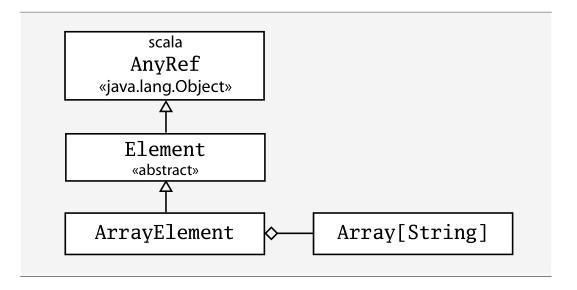
继承（inheritance）的意思是超类的所有成员也是子类的成员，但是有两个例外。**一是超类的<u>私有成员</u>并不会被子类继承；二是如果子类里已经实现了相同名称和参数的成员，那么该成员不会被继承。**对后面这种情况我们也说子类的成员重写（override）了超类的成员。如果子类的成员是具体的而超类的成员是抽象的，我们也说这个具体的成员实现（implement）了那个抽象的成员。

例如，ArrayElement里的contents方法重写（或者说实现）了Element类的抽象方法contents。[2]与此不同的是，ArrayElement类从Element类继承了width和height这两个方法。例如，假定有一个ArrayElement ae，可以用ae.width来查询其宽度，就像width是定义在ArrayElement类一样：


In [ ]:
val ae = new ArrayElement(Array("hello","world"))
ae.width

子类型（subtying）的意思是子类的值可以被用在任何需要超类的值的场合。例如：

In [ ]:
val e: Element = new ArrayElement(Array("hello"))

变量e的类型是Element，因此用于初始化它的值也应该是一个Element。**事实上，初始值的类型是ArrayElement。这是可以的，因为ArrayElement类扩展自Element，这样，ArrayElement类型是与Element类型兼容的。**[3]

图10.1还展示了ArrayElement和Array[String]之间存在的组合（composition）关系。这个关系被称为组合，因为ArrayElement是通过使用Array[String]组合出来的，Scala编译器会在为ArrayElement生成的二进制类文件中放入一个指向传入的conts数组的字段。我们将在本章稍后的10.11节探讨关于组合和继承的设计考量点。

## 10.5 重写方法和字段
统一访问原则只是Scala比Java在处理字段和方法上更加统一的一个方面。另一个区别是Scala中字段和方法属于同一个命名空间。这使得用字段重写无参方法变为可能。举例来说，可以将ArrayElement类中的contents实现从方法改成字段，这并不需要修改Element类中的contents定义，如示例10.4所示：


In [ ]:
class ArrayElement(conts: Array[String]) extends Element {
    val contents: Array[String] = conts
}

这个版本的ArrayElement中的contents字段（用val定义）是Element类的contents方法（用def定义）的一个没有问题的好实现。另一方面，Scala也禁止在同一个类中使用相同的名称命名字段和方法，在Java中这是允许的。

例如，下面这个Java类可以正常编译：
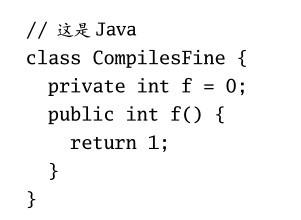
相应的Scala类则不能：

In [ ]:
//class WontCompile {
//    private var f = 0 //不能编译，因为字段
//    def f = 1          //和方法重名了
//}

一般来说，Scala只有两个命名空间用于定义，不同于Java的四个。Java的四个命名空间分别是：字段、方法、类型和包，而Scala的两个命名空间分别是：

● 值（字段、方法、包和单例对象）

● 类型（类和特质名）

Scala将字段和方法放在同一个命名空间的原因正是为了让你可以用val来重写一个无参方法，这在Java中是不允许的。[4]

## 10.6 定义参数化字段
让我们再来看看前一节定义的ArrayElement类。它有一个conts参数，这个参数存在的唯一目的就是被拷贝到contents字段上。参数的名称选用conts也是为了让它看上去跟字段名contents相似但又不至于跟它冲突。这是个“代码的坏味道”（code smell），是你的代码可能存在不必要的冗余和重复的一种信号。

**可以通过将参数和字段合并成参数化字段（parametric field）定义的方式来避免这个坏味道**，如示例10.5所示：


In [ ]:
class ArrayElement(val contents: Array[String]) extends Element
val ae = new ArrayElement(Array("hello","world"))
ae.width

注意，现在contents参数前面放了一个val。这是同时定义参数和同名字段的简写方式。具体来说，ArrayElement类现在具备一个（不能被重新赋值的）contents字段，该字段可以被外界访问到。该字段被初始化为参数的值。这就好像类定义是如下的样子，其中x123是这个参数的一个任意起的新名：
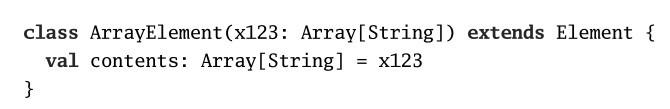
你也可以在类参数的前面加上var，这样的话对应的字段就可以被重新赋值。最后，你还可以给这些参数化字段添加修饰符，比如private、protected[5]或者overried，就像你能够对其他类成员做的那样。例如下面这些类定义：

In [ ]:
  class Cat {
    val dangerous = false
  }
  class Tiger(
    override val dangerous: Boolean,
    private var age: Int
  ) extends Cat

val cat = new Cat()
cat.dangerous
val tiger = new Tiger(true,10)
tiger.dangerous

Tiger的定义是如下这个包含重写成员dangerous和私有成员age的类定义的简写方式：

In [ ]:
class Cat(val dangerous: Boolean = false)
class Tiger(param1: Boolean, param2: Int) extends Cat {
    override val dangerous = param1
    private var age = param2
}

val cat = new Cat()
cat.dangerous
val tiger = new Tiger(true,10)
tiger.dangerous

这两个成员都通过对应的参数初始化。我们选择param1和param2这两个名字是非常随意的，重要的是它们并不跟当前作用域的其他名称相冲突。

## 10.7 调用超类构造方法
你现在已经拥有一个由两个类组成的完整系统：一个抽象类Element，这个类又被另一个具体类ArrayElement扩展。你可能还会看到其他方式来表达一个元素。比如，使用方可能要创建一个由字符串给出的单行组成的布局元素。面向对象的编程让我们很容易用新的数据变种来扩展一个已有的系统，只需要添加子类即可。举例来说，示例10.6给出了一个扩展自ArrayElement的LineElement类：

In [ ]:
abstract class Element {
    def contents: Array[String]//抽象成员，没有具体的实现方法
    def height: Int = contents.length
    def width: Int = if(height == 0) 0 else contents(0).length
}

//这里使用了参数化字段，由于参数化字段与超类的无参抽象成员同名，超类的contents被实现
class ArrayElement(val contents: Array[String]) extends Element

//注意这里extends后对ArrayElement有传参
//这里子类LineElement调用了超类Arraylement的构造函数
//使得子类中contents被定义为 Array(s)
class LineElement(s: String) extends ArrayElement(Array(s)) {
    override def width = s.length
    override def height = 1
}

In [ ]:
val le = new LineElement("hello")

In [ ]:
le.width

In [ ]:
le.contents

由于LineElement扩展自ArrayElement，而ArrayElement的构造方法接收一个参数（Array[String]）,LineElement需要向其超类的主构造方法传入这样一个入参。要调用超类的构造方法，只需将你打算传入的入参放在超类名称后的圆括号里即可。例如，LineElement类就是将Array（s）放在其超类ArrayElement名称后面的圆括号里来将其传入ArrayElement的主构造方法：
`... extends ArrayElement(Array(s)) ...`
有了新的子类，布局元素的类继承关系如图10.2所示。
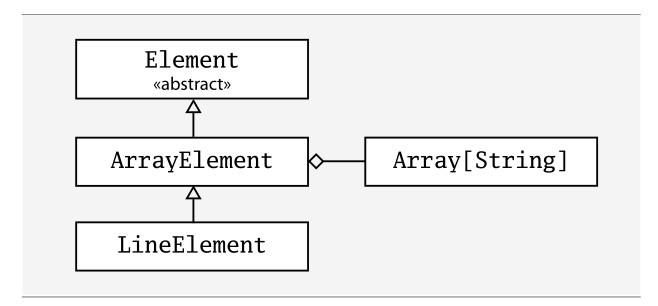

## 10.8 使用override修饰符
注意，LineElement的width和height的定义前面都带上了override修饰符。在6.3节的toString方法的定义中看到过这个修饰符。Scala要求我们在所有重写了父类具体成员的成员之前加上这个修饰符。而如果某个成员并不重写或继承基类中的某个成员，这个修饰符则是被禁用的。由于LineElement的height和width的确是重写了Element类中的具体定义， override这个修饰符是必需的。

这样的规则为编译器提供了有用的信息，帮助我们避免某些难以捕获的错误，让系统得以更加安全地进化。举例来说，如果你碰巧拼错了方法或不小心给出了错误的参数列表，编译器将反馈出错误消息：  
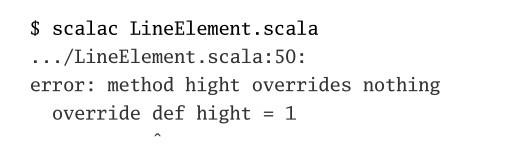

这个override的规约对于系统进化来说更为重要。比方说你打算定义一个2D绘图方法的类库。你公开了这个类库，并且有很多人使用。在这个类库的下一个版本，你打算给你的基类Shape添加一个新的方法，签名如下：  
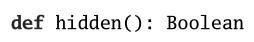

你的新方法将被多个绘图方法用来判定某个形状是否需要被绘制出来。这有可能会带来巨大的性能提升，不过你没法在不产生破坏使用方代码的风险的情况下添加这个方法。毕竟，类库的使用者可能定义了带有不同hidden实现的Shape子类。也许使用方的方法实际上会让接收调用的对象消失而不是测试该对象是否是隐藏的。由于两个版本的hidden存在重写的关系，你的绘图方法最终会让对象消失，这显然并不是你要的效果！

这些“**不小心出现的重写**”是所谓的“脆弱基类”（fragile base class）问题最常见的表现形式。这个问题之所以存在，原因是如果你在某个类继承关系中对基类（我们通常叫作超类）添加新的成员，你将面临破坏使用方代码的风险。Scala并不能完全解决脆弱基类的问题，但它相比Java对此情况有所改善。[6]如果这个绘图类库和使用方代码是用Scala编写的，那么使用方代码中原先的hidden实现并不会带上override修饰符，因为在当时并没有其他方法使用了这个名称。
一旦你在第二版的Shape类添加了hidden方法，重新编译使用方代码将会给出类似如下的报错：
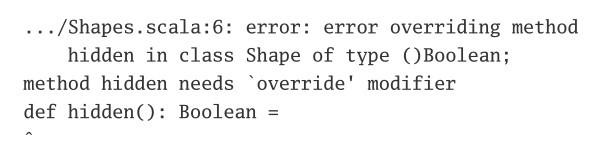

**也就是说，使用你类库的代码并不会表现出错误的行为，而是得到一个编译期错误，这通常是更优的选择。使用方看到这个错误可自行决定如何处理**

## 10.9 多态和动态绑定
你在10.4节看到了，类型为Element的变量可以指向一个类型为ArrayElement的对象。这个现象的名称叫作多态（polymorphism），意思是“多个形状”或“多种形式”。在我们的这个例子中，Element对象可以有许多不同的展现形式。[7]

到目前为止，你看到过两种形式：ArrayElement和LineElement。可以通过定义新的Element子类来创建更多形式的Element。例如，可以定义一个新形式的Element，有一个指定的宽度和高度，并用指定的字符填充：


In [16]:
class UniformElement(
    ch: Char,//不是参数化字段，传入一个字符ch
    override val width: Int,//参数化字段，重新定义width
    override val height: Int//参数化字段，重新定义height
) extends Element {
    private val line = ch.toString * width//Char型转化为String型，复制为宽度width
    def contents = Array.fill(height)(line)//copy height行line，调用了Array的fill方法
}

defined class UniformElement

Element类现在的类继承关系如图10.3所示。有了这些，Scala将会接收如下所有的赋值，因为用来赋值的表达式满足定义变量的类型要求：

In [17]:
val e1: Element = new ArrayElement(Array("hello","world"))
val ae: ArrayElement = new LineElement("hello")
val e2: Element = ae
val e3: Element = new UniformElement('x',2,3)

e1: Element = ammonite.$sess.cmd10$Helper$ArrayElement@61070c99
ae: ArrayElement = ammonite.$sess.cmd10$Helper$LineElement@75b5883a
e2: Element = ammonite.$sess.cmd10$Helper$LineElement@75b5883a
e3: Element = ammonite.$sess.cmd15$Helper$UniformElement@237af3e8

In [18]:
e1.contents

res17: Array[String] = Array("hello", "world")

In [19]:
ae.contents

res18: Array[String] = Array("hello")

In [20]:
e2.contents

res19: Array[String] = Array("hello")

In [21]:
e3.contents

res20: Array[String] = Array("xx", "xx", "xx")

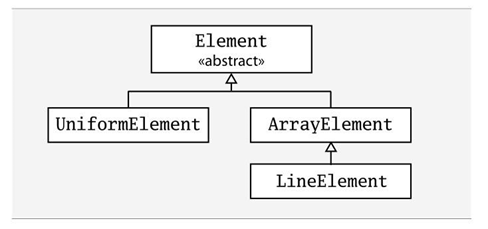

如果你检查这个类继承关系，你会发现对这四个val定义当中的每一个而言，等号右边的表达式类型都位于等号左边被初始化的val的类型的下方。
**不过，故事的另一面是对变量和表达式的方法调用是动态绑定（dynamic bound）的。意思是说实际被调用的方法实现是在运行时基于对象的类来决定的，而不是变量或表达式的类型决定的**。为了展示这个行为，我们将从Element类中临时去掉所有的成员，并向Element添加一个名为demo的方法。我们将在ArrayElement和LineElement中重写demo，但在UniformElement中不重写这个方法：

In [22]:
  abstract class Element {
    def demo() = {
      println("Element's implementation invoked")
    }
  }

  class ArrayElement extends Element {
    override def demo() = {
      println("ArrayElement's implementation invoked")
    }
  }

  class LineElement extends ArrayElement {
    override def demo() = {
      println("LineElement's implementation invoked")
    }
  }

  // UniformElement inherits Element's demo
  class UniformElement extends Element 

defined class Element
defined class ArrayElement
defined class LineElement
defined class UniformElement

如果你将上述代码录入解释器，接下来可以定义如下这样一个方法，接收Element参数，并对它调用demo：

In [24]:
def invokeDemo(e: Element) = {
    e.demo()
}

defined function invokeDemo

如果你传入ArrayElement给invokeDemo，你会看到一条消息，表明是ArrayElement的demo实现被调用了，尽管变量e（即接收demo调用的那个）的类型是Element：

In [25]:
invokeDemo(new ArrayElement)

ArrayElement's implementation invoked


同理，如果你传入LineElement给invokeDemo，你将会看到一条消息，表明是LineElement的demo实现被调用了 ：

In [26]:
invokeDemo(new LineElement)

LineElement's implementation invoked


传入UniformElement后的行为乍看上去有些奇怪，但却是正确的：

In [27]:
invokeDemo(new UniformElement)

Element's implementation invoked


由于UniformElement并没有重写demo，它从其超类Element继承了demo的实现。因此，当对象的类为UniformElement时，调用demo的正确版本就是来自Element类的demo实现。

In [ ]:
object Ex9  {
  abstract class Element {
    def contents: Array[String]
    def height: Int = contents.length
    def width: Int = if (height == 0) 0 else contents(0).length
  }

  class ArrayElement(
    val contents: Array[String]
  ) extends Element

  class LineElement(s: String) extends ArrayElement(Array(s)) {
    override def width = s.length
    override def height = 1
  }

  class UniformElement(
    ch: Char, 
    override val width: Int,
    override val height: Int 
  ) extends Element {
    private val line = ch.toString * width
    def contents = Array.fill(height)(line)
  }

  def main(args: Array[String]) {
    val e1: Element = new ArrayElement(Array("hello", "world"))
    val ae: ArrayElement = new LineElement("hello")
    val e2: Element = ae
    val e3: Element = new UniformElement('x', 2, 3)

    println("e1 [" + e1 + "]")
    println("ae [" + ae + "]")
    println("e2 [" + e2 + "]")
    println("e3 [" + e3 + "]")
  }
}
Ex9.main(Array("test"))

## 10.10 声明final成员
有时，在设计类继承关系的过程中，你想确保某个成员不能被子类继承。在Scala中，跟Java一样，可以通过在成员前面加上final修饰符来实现。如示例10.7所示，可以在ArrayElement的demo方法前放一个final修饰符。

In [28]:
  class ArrayElement extends Element {
    final override def demo() = {
      println("ArrayElement's implementation invoked")
    }
  }

defined class ArrayElement

有了这个版本的ArrayElement，在其子类LineElement中尝试重写demo的话，会导致编译错误：
```scala
  class LineElement extends ArrayElement {

    override def demo() = {

      println("LineElement's implementation invoked")

    }

  }

cmd28.sc:2: overriding method demo in class ArrayElement of type ()Unit;
 method demo cannot override final member
    override def demo() = {
                 ^Compilation Failed

Compilation Failed
```

你可能有时候还想要确保整个类没有子类，可以简单地将类声明为final的，做法是在类声明之前添加final修饰符。例如，示例10.8给出了声明ArrayElement为final的做法：

In [29]:
  final class ArrayElement extends Element {
    override def demo() = {
      println("ArrayElement's implementation invoked")
    }
  }

defined class ArrayElement

有了这样的ArrayElement定义，任何想要定义其子类的尝试都无法通过编译：
```scala
  class LineElement extends ArrayElement {

    override def demo() = {

      println("LineElement's implementation invoked")

    }

  }

cmd29.sc:1: illegal inheritance from final class ArrayElement
class LineElement extends ArrayElement {
                          ^Compilation Failed

Compilation Failed
```

我们现在将去掉final修饰符和demo方法，回到Element家族的早期实现。我们将在本章剩余部分集中精力完成该布局类库的一个可工作版本。

In [30]:
abstract class Element {
    def contents: Array[String]//抽象成员，没有具体的实现方法
    def height: Int = contents.length
    def width: Int = if(height == 0) 0 else contents(0).length
}

//这里使用了参数化字段，由于参数化字段与超类的无参抽象成员同名，超类的contents被实现
class ArrayElement(val contents: Array[String]) extends Element

//注意这里extends后对ArrayElement有传参
//这里子类LineElement调用了超类Arraylement的构造函数
//使得子类中contents被定义为 Array(s)
class LineElement(s: String) extends ArrayElement(Array(s)) {
    override def width = s.length
    override def height = 1
}

class UniformElement(
    ch: Char,//不是参数化字段，传入一个字符ch
    override val width: Int,//参数化字段，重新定义width
    override val height: Int//参数化字段，重新定义height
) extends Element {
    private val line = ch.toString * width//Char型转化为String型，复制为宽度width
    def contents = Array.fill(height)(line)//copy height行line，调用了Array的fill方法
}

defined class Element
defined class ArrayElement
defined class LineElement
defined class UniformElement

## 10.11 使用组合和继承
组合和继承是两种用其他已有的类来定义新类的方式。如果你主要追求的是代码复用，**一般来说你应当优先选择组合而不是继承**。只有继承才会受到脆弱基类问题的困扰，会在修改超类时不小心破坏了子类的代码。

关于继承关系，你可以问自己一个问题，那就是要建模的这个关系是否是is-a（是一个）的关系。[8]例如，我们有理由说ArrayElement是一个Element。另一个可以问的问题是这些类的使用方是否会把子类的类型当作超类的类型来使用。[9]以ArrayElement为例，我们确实是预期使用方会将ArrayElement作为Element来用。
如果你对图10.3中的继承关系发问上述两个问题，有没有哪个关系看上去比较可疑？具体来说，你是否觉得LineElement理所应当是一个ArrayElement呢？你是否认为使用方会需要把LineElement当作是ArrayElement来用呢？

**事实上，我们将LineElement定义为ArrayElement的子类的主要目的是复用ArrayElement的contents定义。因此，也许更好的做法是将LineElement定义为Element的直接子类，就像这样：**

In [31]:
class LineElement(s: String) extends Element {
    val contents = Array(s)
    override def width = s.length
    override def height = 1
}

defined class LineElement

In [ ]:
object Ex11  {
  abstract class Element {
  
    def contents: Array[String]
  
    def width: Int =
      if (height == 0) 0 else contents(0).length
  
    def height: Int = contents.length
  
    def above(that: Element): Element =
      new ArrayElement(this.contents ++ that.contents)
  
    def beside(that: Element): Element =
      new ArrayElement(
        for (
          (line1, line2) <- this.contents zip that.contents
        ) yield line1 + line2
      )
  
    override def toString = contents mkString "\n"
  }

  class LineElement(s: String) extends Element {
    val contents = Array(s)
    override def width = s.length
    override def height = 1
  }

  class ArrayElement(conts: Array[String]) extends Element {
    def contents: Array[String] = conts
  }

  def main(args: Array[String]) {
    val lineElem = new LineElement("foo")
    println("lineElem [" + lineElem + "]")

  }
}

在前一个版本中，LineElement有一个跟ArrayElement的继承关系，它继承了contents。现在LineElement有一个跟Array的组合关系：它包含了一个从自己的contents字段指向一个字符串数组的引用。[10]有了这个版本的LineElement实现，Element的类继承关系如图10.4所示。
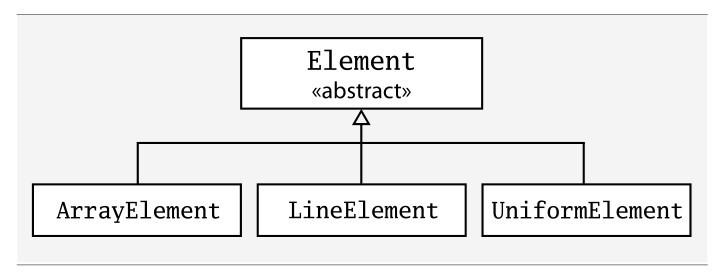

## 10.12 实现above、beside和toString
接下来，我们将实现Element类的above方法。将某个元素放在另一个“上面”意味着将两个元素的值拼接在一起。第一版的above方法可能是这样的：

In [35]:
object Ex11  {
  abstract class Element {
    def contents: Array[String]
    def width: Int =
      if (height == 0) 0 else contents(0).length
    def height: Int = contents.length
      
    def above(that: Element): Element =
      new ArrayElement(this.contents ++ that.contents)
  }

  class LineElement(s: String) extends Element {
    val contents = Array(s)
    override def width = s.length
    override def height = 1
  }

  class ArrayElement(val contents: Array[String]) extends Element

//   def main(args: Array[String]) {
//     val lineElem = new LineElement("foo")
//     println("lineElem [" + lineElem + "]")
//   }
}

defined object Ex11

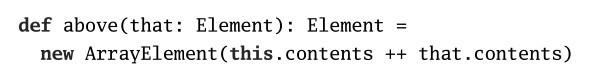
其中++这个操作将两个数组拼接在一起。Scala中的数组是用Java的数组表示的，不过支持更多的方法。具体来说，Scala的数组可以被转换成scala. Seq类的示例这个类代表了类似于序列的结构，包含了访问和转换序列的若干方法。本章还会讲到数组支持的其他一些方法，然后在第17章还会有更详细的讨论。

事实上，前面给出的代码并不是很够用，因为它并不允许你将宽度不同的元素叠在一起。不过为了让事情保持简单，我们将不理会这个问题，只是每次都记得传入相同长度的元素给above。在10.14节，我们将对above做增强，让使用方可以用它来拼接不同宽度的元素。

下一个要实现的方法是beside。要把两个元素并排放在一起，我们将创建一个新的元素。在这个新元素中，每一行都是由两个元素的对应行拼接起来的。跟之前一样，为了让事情保持简单，我们一开始假定两个元素有相同的高度，这让我们设计出下面这个beside方法：
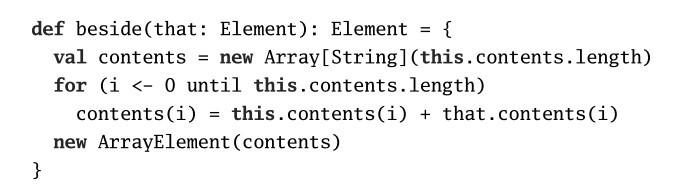
这个beside方法首先分配一个新的数组contents，用this.contents和that.contents对应的数组元素拼接的字符串数组填充。最后，产生一个新的包含新的contents的ArrayElement。
虽然这个beside的实现可以解决问题，它是用指令式风格编写的，明显的标志是我们用下标遍历数组时使用的循环。换一种方式，可以将这个方法简化为一个表达式：
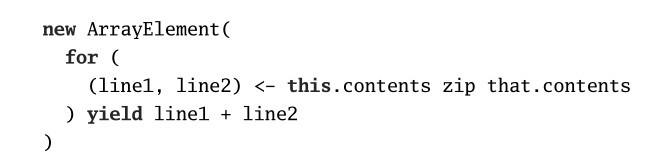
在这里，我们用zip操作符将this.contents和that.contents这两个数组转换成对偶（即Tuple2）的数组。这个zip操作符从它的两个操作元中选取对应的元素，组装成一个对偶（pair）的数组。例如，如下表达式：
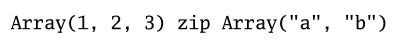
将被求值为：
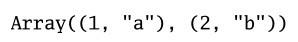
如果其中一个操作元数组比另一个长，zip将会扔掉多余的元素。在上面的表达式中，左操作元的第三个元素3并没有进入结果，因为它在右操作元中并没有对应的元素。

接下来，这个zip起来的数组被一个for表达式遍历。在这里，“for （（line1, line2）<- ...）”这样的语法允许你在一个模式（pattern）中同时对两个元素命名（也就是说line1表示对偶的第一个元素，而line2表示对偶的第二个元素）。我们将在第15章详细介绍Scala的模式匹配系统。就现在而言，你可以认为这是在迭代中的每一步定义两个val（line1和line2）的一种方式。

for表达式有一个部分叫作yield，通过yield交出结果。这个结果的类型和被遍历的表达式是同一种（也就是数组）。数组中的每个元素都是将对应的行line1和line2拼接起来的结果。因此这段代码的最终结果跟第一版的beside一样，不过由于它避免了显式的数组下标，获取结果的过程更少出错。

你还需要某种方式来显示元素。跟往常一样，这是通过定义返回格式化好的字符串的toString方法完成的。定义如下：
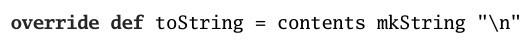
toString的实现用到了mkString，这个方法对所有序列都适用，包括数组。如你在7.8节看到的，类似“arr mkString sep”这样的表达式将返回一个包含arr数组所有元素的数组。每个元素都通过toString被映射成字符串。在连续的字符串元素中间，还会插入一个sep字符串用作分隔。因此，“contents mkString ＂\n＂”这样的表达式将contents数组格式化成一个字符串，每个数组元素都独占一行。
**注意，toString并没有带上一个空参数列表。这符合统一访问原则的建议，因为toString是一个不接收任何参数的纯方法。**有了这三个方法，Element类现在看上去如示例10.9所示。

In [ ]:
abstract class Element {
    def contents: Array[String]
    def height: Int = contents.length
    def width: Int = if (height == 0) 0 else contents(0).length

    def above(that: Element): Element =
      new ArrayElement(this.contents ++ that.contents)

    def beside(that: Element): Element = 
      new ArrayElement(
        for (
          (line1, line2) <- this.contents zip that.contents
        ) yield line1 + line2
      )

    override def toString = contents.mkString("\n")

  }

  class LineElement(s: String) extends Element {
    val contents = Array(s)
    override def width = s.length
    override def height = 1
  }

  class ArrayElement(conts: Array[String]) extends Element {
    def contents: Array[String] = conts
  }

  class UniformElement(
    ch: Char, 
    override val width: Int,
    override val height: Int 
  ) extends Element {
    private val line = ch.toString * width
    def contents = Array.fill(height)(line)
  }


    val lineElem = new LineElement("foo")
    val lineElem2 = lineElem.above(lineElem)
    println("lineElem [" + lineElem + "]")

    val zip1 =
      Array(1, 2, 3) zip Array("a", "b")
    val zip2 =
      Array((1, "a"), (2, "b"))
    println("zip1 [" + zip1 + "]")
    println("zip2 [" + zip2 + "]")


## 10.13 定义工厂对象
现在你已经拥有一组用于布局元素的类。这些类的继承关系可以“原样”展现给你的使用方，不过你可能想把继承关系藏在一个工厂对象背后。

工厂对象包含创建其他对象的方法。使用方用这些工厂方法来构造对象，而不是直接用new构建对象。这种做法的好处是对象创建逻辑可以被集中起来，而对象是如何用具体的类表示的可以被隐藏起来。这样既可以让你的类库更容易被使用方理解，因为暴露的细节更少，同时还提供了更多的机会让你在未来在不破坏使用方代码的前提下改变类库的实现。

为布局元素构建工厂的第一个任务是选择在哪里放置工厂方法。工厂方法应该作为某个单例对象的成员，还是类的成员？包含工厂方法的对象或类应该如何命名？可能性有很多。**直接的方案是创建一个Element类的伴生对象，作为布局元素的工厂对象**。这样，你只需要暴露Element这组类/对象给使用方，并将ArrayElement、LineElement和UniformElement这三个实现类隐藏起来。

示例10.10给出了按这个机制做出的Element对象设计。Element对象包含了三个重载的elem方法，每个方法构建不同种类的布局对象。

In [ ]:
object Element {
  class LineElement(s: String) extends Element {
    val contents = Array(s)
    override def width = s.length
    override def height = 1
  }

  class ArrayElement(conts: Array[String]) extends Element {
    def contents: Array[String] = conts
  }

  class UniformElement(
    ch: Char, 
    override val width: Int,
    override val height: Int 
  ) extends Element {
    private val line = ch.toString * width
    def contents = Array.fill(height)(line)
  }

    
    def elem(contents: Array[String]): Element = 
        new ArrayElement(contents)
    def elem(chr: Char, width: Int, height: Int): Element = 
        new UniformElement(chr,width,height)
    def elem(s: String): Element = 
        new LineElement(s)
}

有了这些工厂方法以后，我们有理由将Element类的实现做一些改变，让它用elem工厂方法，而不是直接显式地创建新的ArrayElement。为了在调用工厂方法时不显式给出Element这个单例对象名称的限定词，我们将在源码文件顶部引入Element.elem。换句话说，我们在Element类中不再用Element.elem来调用工厂方法，而是引入Element.elem，这样我们就可以用它们的简单名字，即elem，来调用工厂方法了。示例10.11给出了调整过后的Element类。

In [ ]:
//import Element.elem
object Element {
  private class LineElement(s: String) extends Element {
    val contents = Array(s)
    override def width = s.length
    override def height = 1
  }

  private class ArrayElement(conts: Array[String]) extends Element {
    def contents: Array[String] = conts
  }

  private class UniformElement(
    ch: Char, 
    override val width: Int,
    override val height: Int 
  ) extends Element {
    private val line = ch.toString * width
    def contents = Array.fill(height)(line)
  }

    
    def elem(contents: Array[String]): Element = 
        new ArrayElement(contents)
    def elem(chr: Char, width: Int, height: Int): Element = 
        new UniformElement(chr,width,height)
    def elem(s: String): Element = 
        new LineElement(s)
}

import Element.elem
abstract class Element {
    def contents: Array[String]
    def height: Int = contents.length
    def width: Int = if (height == 0) 0 else contents(0).length

    def above(that: Element): Element =
        elem(this.contents ++ that.contents)

    def beside(that: Element): Element = 
        elem(
        for (
          (line1, line2) <- this.contents zip that.contents
        ) yield line1 + line2
      )

    override def toString = contents.mkString("\n")

}

除此之外，有了工厂方法后，ArrayElement、LineElement和UniformElement这些子类可以变成私有的，因为它们不再需要被使用方直接访问了。在Scala中，可以在其他类或单例对象中定义类和单例对象。将Element的子类变成私有的方式之一是将它们放在Element单例对象当中，并声明为私有。这些类在需要时仍可以被那三个elem工厂方法访问到。示例10.12给出了这些修改过后的样子。

In [ ]:
//import Element.elem
object Element {
  private class LineElement(s: String) extends Element {
    val contents = Array(s)
    override def width = s.length
    override def height = 1
  }

  private class ArrayElement(conts: Array[String]) extends Element {
    def contents: Array[String] = conts
  }

  private class UniformElement(
    ch: Char, 
    override val width: Int,
    override val height: Int 
  ) extends Element {
    private val line = ch.toString * width
    def contents = Array.fill(height)(line)
  }

    
    def elem(contents: Array[String]): Element = 
        new ArrayElement(contents)
    def elem(chr: Char, width: Int, height: Int): Element = 
        new UniformElement(chr,width,height)
    def elem(s: String): Element = 
        new LineElement(s)
}

import Element.elem
abstract class Element {
    def contents: Array[String]
    def height: Int = contents.length
    def width: Int = if (height == 0) 0 else contents(0).length

    def above(that: Element): Element =
        elem(this.contents ++ that.contents)

    def beside(that: Element): Element = 
        elem(
        for (
          (line1, line2) <- this.contents zip that.contents
        ) yield line1 + line2
      )

    override def toString = contents.mkString("\n")

}

## 10.14 增高和增宽
我们还需要最后一个增强。示例10.11给出的Element并不是很够用，因为它不允许使用方将不同宽度的元素叠加在一起，或者将不同高度的元素并排放置。
例如，对如下表达式求值不能正常工作，因为第二行合起来的元素比第一行要长：

In [ ]:
println(elem(Array("hello")) above elem(Array("world")))

In [ ]:
println(elem(Array("hello")) above elem(Array("world!")))//can't work

同理，对下面的表达式求值也不能正常工作，因为第一个ArrayElement的高度是2，而第二个ArrayElement的高度是1：

In [ ]:
println(elem(Array("one","two")) beside elem(Array("one")))

示例10.13展示了一个私有的助手方法widen，接收一个宽度参数并返回这个宽度的元素。结果包含了这个Element元素的内容，两侧用空格填充，来达到要求的宽度。示例10.13还展示了另一个类似的方法heighten，执行同样的功能，只不过方向变成了纵向的。above可以调用widen来保证叠加起来的Elements拥有相同的宽度。同样地，beside可以借助heighten方法来确保并排放置的元素可以有相同的高度。做了这些改变之后，我们的这个布局类库可以用起来了。

In [ ]:
object Element {
  private class LineElement(s: String) extends Element {
    val contents = Array(s)
    override def width = s.length
    override def height = 1
  }

  private class ArrayElement(conts: Array[String]) extends Element {
        def contents: Array[String] = conts
        //def widthOfLength(s: String) = s.length
        val longestLine = conts.reduceLeft(
            (a, b) => if (a.length > b.length) a else b
            )
        override def width = longestLine.length
  }

  private class UniformElement(
    ch: Char, 
    override val width: Int,
    override val height: Int 
  ) extends Element {
    private val line = ch.toString * width
    def contents = Array.fill(height)(line)
  }

    
    def elem(contents: Array[String]): Element = 
        new ArrayElement(contents)
    def elem(chr: Char, width: Int, height: Int): Element = 
        new UniformElement(chr,width,height)
    def elem(s: String): Element = 
        new LineElement(s)
}  

import Element.elem

  abstract class Element {
    def contents:  Array[String]

    def width: Int = contents(0).length
    def height: Int = contents.length

    def above(that: Element): Element = {
      val this1 = this widen that.width
      val that1 = that widen this.width
      elem(this1.contents ++ that1.contents)
    }

    def beside(that: Element): Element = {
      val this1 = this heighten that.height
      val that1 = that heighten this.height
      elem(
        for ((line1, line2) <- this1.contents zip that1.contents) 
        yield line1 + line2)
    }

    def widen(w: Int): Element = 
      if (w <= width) this
      else {
        val left = elem(' ', (w - width) / 2, height) 
        val right = elem(' ', w - width - left.width, height)
        left beside this beside right
      }

    def heighten(h: Int): Element = 
      if (h <= height) this
      else {
        val top = elem(' ', width, (h - height) / 2)
        val bot = elem(' ', width, h - height - top.height)
        top above this above bot
      }

    override def toString = contents mkString "\n"
  }

println(elem(Array("one","two","three")).width)
println(elem(Array("one","two","three")) beside elem(Array("one")))

## 10.15 放在一起
练习使用布局类库的几乎所有元素的趣味方式是编写一个用给定的边数（edge）绘制螺旋的程序。示例10.14给出的Spiral就是这样一个程序。

In [ ]:
  import Element.elem

  object Spiral {

    val space = elem(" ")
    val corner = elem("+")

    def spiral(nEdges: Int, direction: Int): Element = {
      if (nEdges == 1)
        elem("+")
      else {
        val sp = spiral(nEdges - 1, (direction + 3) % 4)
        def verticalBar = elem('|', 1, sp.height)
        def horizontalBar = elem('-', sp.width, 1)
        if (direction == 0)
          (corner beside horizontalBar) above (sp beside space)
        else if (direction == 1)
          (sp above space) beside (corner above verticalBar)
        else if (direction == 2)
          (space beside sp) above (horizontalBar beside corner)
        else
          (verticalBar above corner) beside (space above sp)
      }
    }

    def main(args: Array[String]) = {
      val nSides = args(0).toInt
      println(spiral(nSides, 0))
    }
  }

Spiral.main(Array("6"))
Spiral.main(Array("11"))
Spiral.main(Array("17"))

## 10.16 结语
在本章中，你看到了更多关于Scala面向对象编程的概念。在这当中，你接触到了抽象类、继承和子类型、类继承关系、参数化字段，以及方法重写。你应该已经建立起一种用Scala构建一定规模的类继承关系图谱的感觉。我们将在第14章再一次用到这个布局类库。

________________________________________
[1].Meyer，面向对象的软件构建 [May00]  
[2].这个设计有一个缺陷，因为返回的数组是可变的，所以你的使用方可以改变它。对本书而言我们将简单处理，但如果ArrayElememt是某个实际项目的一部分，可能需要考虑返回该数组的一个保护性拷贝（defensive copy）。另一个问题是我们目前并没有确保contents的每个String元素都有相同的长度。这个问题可以通过在主构造方法中检查前提条件并在前提条件不满足时抛出异常来解决。  
[3].关于子类和子类型的区别的更多描述，请参考术语表中的subtype词条。  
[4].Scala中包也跟字段和方法共用一个命名空间的原因是让你能引入包（而不仅仅是类型的名称）及单例对象的字段和方法。这同样是Java不允许的。我们将在13.3节做更详细的介绍。  
[5].我们将在第13章详细介绍protected这个用来给子类赋予访问权的修饰符。  
[6].Java在1.5版本引入了@Override注解，工作机制跟Scala的override修饰符类似，但不同于Scala的override，这个注解并不是必需的。  
[7].这一类多态被称为子类型多态（subtyping polymorphism）。Scala还有另一种多态，全类型多态（universal polymorphism），我们将在第19章做详细介绍（全类型多态通常被称为参数多态，即parametric polymorphism。——译者注）。  
[8].Meyers,《Effective C++》[Mey91]  
[9].Eckel,《Thinking in Java》[Eck98]  
[10].ArrayElement类也有个跟Array的组合关系，因为它的参数化字段contents包含了指向一个字符串数组的引用。ArrayElement的代码如示例10.5所示（188页）。其组合关系在类图中表示为菱形，如图10.1（185页）所示。

## 笔记
### 抽象成员与抽象类
```scala
abstract class Element {
    def contents: Array[String]//抽象成员，没有具体的实现方法
}
```
contents是一个抽象成员，其并没有具体的实现方法，或者说它是指一个声明(declaration)而不是定义(definition)，一个包含抽象成员的类需要定义为抽象类，方法是在类前加abstract关键词。例如：
```scala
abstract class Element...
```
抽象类中的抽象成员被定义以后，这个抽象类才能被实例化。

### 无参访法实现字段与方法的转化
1. 一个没有参数的方法即无参方法，无参方法没有圆括号。定义成  
`def width: Int`  
2. 如果一个方法没有参数，但是定义时加了圆括号，则称之为空圆括号方法(empty-paren method)。  
3. Scala禁止同一个类中使用同样的名称命名字段和方法
> **推荐的做法是对于没有参数且只通过读取所在对象字段的方式不改变状态的情况下尽量使用无参方法。这样的做法支持所谓的统一访问原则（uniform access principle），使用方代码不应受到某个属性是用字段还是用方法实现的影响。**  

我们可以直接将无参方法用字段实现，如下：
```scala
abstract class Element {
    def contents: Array[String]//抽象成员，没有具体的实现方法
    //def height: Int = contents.length //无参方法
    //def width: Int = if(height == 0) 0 else contents(0).length //无参方法
    val height: Int = contents.length //height改成了字段
    val width: Int = if(height == 0) 0 else contents(0).length //width改成了字段
}
```
属性实现为字段好还是方法好，这个问题取决于类的用法，而用法可以是随着时间变化而变化的。核心点在于Element类的使用方不应该被内部实现的变化所影响。

无参方法和空圆括号方法调用时空圆括号可加可不加，对于有副作用的方法，不建议省去空括号，因为省掉括号以后这个方法调用看上去就像是字段选择，因此你的使用方可能会对其副作用感到意外。  
**换一个角度来思考这个问题，如果你调用的这个函数执行了某个操作，就加上括号，而如果它仅仅是访问某个属性，则可以省去括号。**

### 扩展类
关键词：`extends`  
1. 子类扩展自超类，子类继承超类私有成员以外的其他信息。  
2. 如果子类实现了（超类的抽象成员）或重写（override）了超类的成员，那么该成员不会被继承。
3. 子类的值可以被用在任何需要超类的值的场合。
4. 子类可以将超类中的无参方法写成字段，也可以将超类的字段写成无参方法。

### 参数化字段
```scala
//非参数化字段
class ArrayElement(conts: Array[String]) extends Element {
    val contents: Array[String] = conts
}
```
```scala
//参数化字段
class ArrayElement(val contents: Array[String]) extends Element
```
现在contents参数前面放了一个`val`。这是同时定义参数和同名字段的简写方式。具体来说，ArrayElement类现在具备一个（不能被重新赋值的）contents字段，该字段可以被外界访问到。该字段被初始化为参数的值。

你也可以在类参数的前面加上`var`，这样的话对应的字段就可以被重新赋值。最后，你还可以给这些参数化字段添加修饰符，比如private、protected[5]或者overried，就像你能够对其他类成员做的那样。


### 调用超类的构造方法
要调用超类的构造方法，只需将你打算传入的入参放在超类名称后的圆括号里即可。

### 多态和动态绑定
1. 超类类型的变量可以指向子类类型的对象，这个就叫做多态，意思是“多个形状”或“多种形式”，因为子类有多种形态。
2. 变量和表达式的方法调用是动态绑定（dynamic bound）的。意思是说实际被调用的方法实现是在运行时基于对象的类来决定的，而不是变量或表达式的类型决定的。